In [1]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torchinfo import summary
from tqdm import tqdm
from scipy import signal

## Loading Data

In [2]:
# data_dir = "/Users/rmdim/Documents/MASc/Fall22/599Code/norm_fog_data_2/"
data_dir = "/root/trevor/syde599/norm_fog_data/"

data_files = glob.glob(data_dir + "*.csv")
len(data_files)

56

In [3]:
WINDOW_SIZE = 650
WINDOW_STEP = 100

train_X = []
train_Y = []
test_X = []
test_Y = []

for file in data_files:
    path_parts = file.split('/')
    patient_num = path_parts[-1].split('_')[0]
    
    data = np.loadtxt(file, delimiter=",", skiprows=1)
    # Timestamp is in col 0, labels are in col 1
    # Data is in cols 2 to end
    y = data[:, 1]
    x = data[:, 2:]

    # # Split into non-overlapping windows
    # # Don't use the last bit of data that doesn't fill a whole window
    # n_windows = y.size // WINDOW_SIZE
    # end = WINDOW_SIZE * n_windows
    # x = x[:end, :]  # (n_samples, d)
    # y = y[:end]

    # # Reshape into (n_windows, window_size, d)
    # x = x.reshape(n_windows, WINDOW_SIZE, -1)
    # y = y.reshape(n_windows, WINDOW_SIZE)

    # Split into overlapping windows
    x = np.lib.stride_tricks.sliding_window_view(x, WINDOW_SIZE, axis=0)[::WINDOW_STEP]
    y = np.lib.stride_tricks.sliding_window_view(y, WINDOW_SIZE, axis=0)[::WINDOW_STEP]

    x = x.transpose(0,2,1)
    
    if patient_num in ('001', '009', '010'):
        test_X.append(x)
        test_Y.append(y)
    else:
        train_X.append(x)
        train_Y.append(y)
    

In [4]:
x.shape

(324, 650, 30)

In [5]:
train_X = np.concatenate(train_X, axis=0)
train_Y = np.concatenate(train_Y, axis=0)

test_X = np.concatenate(test_X, axis=0)
test_Y = np.concatenate(test_Y, axis=0)

## Dataset and Augmentation

In [6]:
class FoGDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        """
        Parameters:
        -----------
        data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
        data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
        """
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        inputs = self.data_x[index, :, :]
        labels = self.data_y[index, :]
        return inputs, labels


class FoGDataAugment:
    """
    Collate function to apply random time stretch/squeeze and signal shrink/scale
    Apply stretch/squeeze to the time dimension by resampling and truncating to out_samples
        The lower bound of stretch must satisfy (lb * len(input)) > out_samples
    """
    def __init__(self, out_samples=512, p=0.5, stretch=(0.8, 1.2), scale=(0.8, 1.2)):
        """
        Parameters:
        -----------
        p: float between [0, 1], probability of applying each the stretch and scale transform independently
        strech: tuple of float, upper and lower bound on time stretch factor
        scale: tuple of float, upper and lower bound on signal scale factor
        """
        self.p = p
        self.stretch = stretch
        self.scale = scale
        self.out_samples = out_samples
    
    def _reduce_labels(self, y):
        """If there is a 1 in the label, then return 1"""
        return np.any(y == 1, axis=-1).astype(int)

    def _random_crop(self, inputs, labels):
        """Apply a random crop of the signal of length self.out_samples to both inputs and labels"""
        n, d = inputs.shape
        max_offset = n - self.out_samples
        offset = np.random.choice(max_offset)
        inds = slice(offset, offset + self.out_samples)
        return inputs[inds, :], labels[inds]

    def __call__(self, data):
        """
        Parameters:
        -----------
        data: list of tuple of (inputs, labels) of length batch_size
            inputs: np.ndarray, dimensions (n_samples, n_channels), signal data
            labels: np.ndarray, dimensions (n_samples,), binary label vector for the signal data

        Returns:
        --------
        (inputs, labels): augmented signal data, reduced labels
        """
        x = []
        y = []
        for (inputs, labels) in data:
            n, d = inputs.shape
            assert (self.stretch[0] * n) >= self.out_samples, f"input size {n} must be greater than {int(self.out_samples / self.stretch[0])} to apply augmentation"

            # Randomly apply time stretch
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.stretch
                stretch = np.random.uniform(lb, ub)
                inputs = signal.resample(inputs, int(n * stretch), axis=0)  # Resample the time (n_samples) axis
            if np.random.binomial(1, self.p) != 0:
                lb, ub = self.scale
                scale = np.random.uniform(lb, ub)
                inputs = scale * inputs  # Scale all channels equally
            
            # Apply random crop to self.out_size on both inputs and labels
            inputs, labels = self._random_crop(inputs, labels)

            labels = self._reduce_labels(labels)
            x.append(inputs)
            y.append(labels)
        x = np.array(x)
        y = np.array(y)
        collated_inputs = torch.tensor(x, dtype=torch.float32)
        collated_labels = torch.tensor(y, dtype=torch.float32)
        return collated_inputs, collated_labels

In [7]:
train_dataset = FoGDataset(train_X, train_Y)
test_dataset = FoGDataset(test_X, test_Y)

augment_fn = FoGDataAugment(out_samples=512)
test_augment = FoGDataAugment(out_samples=512, p=0)


BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=augment_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=test_augment)

# Models

## CNN Module

In [27]:
class CNNModel(nn.Module):
    def __init__(self, input_features=30, mp=2):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv1d(input_features, 32, kernel_size=32, padding=16)
        self.mp = nn.MaxPool1d(mp, stride=mp)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=16, padding="same")

        self.conv3 = nn.Conv1d(64, 128, kernel_size=8, padding="same")

        self.conv4 = nn.Conv1d(128, 256, kernel_size=4, padding="same")


    def forward(self, x):
        """
        Parameters:
        -----------
        x : torch.tensor
            Inputs, of shape (batch, sequence, channels)
        Returns:
        --------
        y : torch.tensor
            Outputs, of shape (batch, sequence, channels)
        """
        x = x.permute(0, 2, 1)  # Permute dims for convolution
        x = self.conv1(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.mp(x)

        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.mp(x)

        x = self.conv3(x)
        # print(x.shape)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.mp(x)
        # print(x.shape)
        y = x.permute(0, 2, 1)  # Permute dims for input to transformer
        return y

In [28]:
inputs = torch.randn(4, 512, 30)

In [29]:
model = CNNModel()

In [30]:
outputs = model(inputs)
outputs.shape

torch.Size([4, 64, 256])

## Transformer model

In [12]:
class TransformerModel(nn.Module):
    def __init__(self, n_layers=3, in_features=30, d_model=128, n_heads=8, dropout=0.1):
        super().__init__()
        self.d_model = d_model

        self.input_transform = nn.Linear(in_features, d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dropout=dropout,
            dim_feedforward=4*d_model,
            activation="gelu",
            batch_first=True,
            norm_first=True)

        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.layer_norm = nn.LayerNorm(d_model)

        # We'll just make a prediction on the features of the first and last sequence point
        self.classifier = nn.Linear(d_model * 2, 1)
    
    def forward(self, x):
        x = self.input_transform(x)
        x = self.encoder(x)
        x = self.layer_norm(x)

        x = x[:, [0, -1], :].reshape(-1, 2 * self.d_model)
        x = self.classifier(x)
        return x

## CNN + Transformer Model

In [31]:
class CnnTransformerModel(nn.Module):
    def __init__(self, n_layers=3, in_features=30, d_model=256, n_heads=8, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        
        self.cnn = CNNModel(input_features=in_features)
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(p=dropout)

        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dropout=dropout,
            dim_feedforward=4*d_model,
            activation="gelu",
            batch_first=True,
            norm_first=True)

        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.layer_norm_2 = nn.LayerNorm(d_model)

        # We'll just make a prediction on the features of the first and last sequence point
        self.classifier = nn.Linear(d_model * 2, 1)
    
    def forward(self, x):
        x = self.cnn(x)
        x = self.layer_norm_1(x)
        x = self.dropout(x)

        x = self.encoder(x)
        x = self.layer_norm_2(x)
        # Take only first and last points in the sequence
        x = x[:, [0, -1], :].reshape(-1, 2 * self.d_model)
        x = self.classifier(x)
        return x

In [32]:
model = CnnTransformerModel()

In [33]:
summary(model)

Layer (type:depth-idx)                                            Param #
CnnTransformerModel                                               --
├─CNNModel: 1-1                                                   --
│    └─Conv1d: 2-1                                                30,752
│    └─MaxPool1d: 2-2                                             --
│    └─Conv1d: 2-3                                                32,832
│    └─Conv1d: 2-4                                                65,664
│    └─Conv1d: 2-5                                                131,328
├─LayerNorm: 1-2                                                  512
├─Dropout: 1-3                                                    --
├─TransformerEncoderLayer: 1-4                                    --
│    └─MultiheadAttention: 2-6                                    197,376
│    │    └─NonDynamicallyQuantizableLinear: 3-1                  65,792
│    └─Linear: 2-7                                                263,1

In [34]:
model(inputs)

tensor([[1.0905],
        [1.1546],
        [0.7119],
        [1.4934]], grad_fn=<AddmmBackward0>)

# Training

In [39]:
def evaluate(model, dataloader, criterion, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            outputs = outputs.flatten()
            loss = criterion(outputs, targets)

            total_loss += loss
            preds = torch.round(torch.sigmoid(outputs))
            correct += torch.sum(preds == targets).detach().cpu()

        accuracy = correct / (dataloader.batch_size * len(dataloader))
        print(f'Eval loss: {total_loss/len(dataloader)} Eval accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader)

In [40]:
def train(model, dataloader, optimizer, criterion, epoch, logging_steps=20, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()
    total_loss = 0
    correct = 0
    loss_history = []
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss
        loss_history.append(loss.item())
        preds = torch.round(torch.sigmoid(outputs))
        correct += torch.sum(preds == targets).detach().cpu()

        if i % logging_steps == 0:
            print(f'Epoch: {epoch} ({i}/{len(dataloader)}) Training loss: {loss}')
            evaluate(model, test_loader, criterion)
            model.train()

    accuracy = correct / (dataloader.batch_size * len(dataloader))
    print(f'Epoch {epoch} done. Training loss: {total_loss/len(dataloader)} Training accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader), loss_history

### Testing Transformer model
Use data augmentation and sliding window

In [36]:
model = TransformerModel(in_features=30, dropout=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.BCEWithLogitsLoss()
EPOCHS = 5

In [37]:
loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(model, train_loader, optimizer, criterion, epoch)
    eval_acc, eval_loss = evaluate(model, test_loader, criterion, epoch)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)
    

2it [00:00,  3.08it/s]

Epoch: 0 (0/721) Training loss: 0.7554233074188232


22it [00:03,  6.22it/s]

Epoch: 0 (20/721) Training loss: 0.6532602310180664


42it [00:07,  6.09it/s]

Epoch: 0 (40/721) Training loss: 0.5206763744354248


62it [00:10,  6.13it/s]

Epoch: 0 (60/721) Training loss: 0.41588354110717773


82it [00:13,  6.13it/s]

Epoch: 0 (80/721) Training loss: 0.3789481222629547


102it [00:16,  6.17it/s]

Epoch: 0 (100/721) Training loss: 0.3623674511909485


122it [00:20,  6.15it/s]

Epoch: 0 (120/721) Training loss: 0.3586186170578003


142it [00:23,  6.17it/s]

Epoch: 0 (140/721) Training loss: 0.3380677103996277


162it [00:26,  6.15it/s]

Epoch: 0 (160/721) Training loss: 0.4361070394515991


182it [00:30,  6.07it/s]

Epoch: 0 (180/721) Training loss: 0.24369420111179352


202it [00:33,  6.13it/s]

Epoch: 0 (200/721) Training loss: 0.33329203724861145


222it [00:36,  6.18it/s]

Epoch: 0 (220/721) Training loss: 0.3188219964504242


242it [00:39,  6.14it/s]

Epoch: 0 (240/721) Training loss: 0.35012319684028625


262it [00:43,  6.05it/s]

Epoch: 0 (260/721) Training loss: 0.285797119140625


282it [00:46,  6.04it/s]

Epoch: 0 (280/721) Training loss: 0.3293449580669403


302it [00:49,  6.19it/s]

Epoch: 0 (300/721) Training loss: 0.21961656212806702


322it [00:52,  6.06it/s]

Epoch: 0 (320/721) Training loss: 0.29697996377944946


342it [00:56,  6.07it/s]

Epoch: 0 (340/721) Training loss: 0.4442707896232605


362it [00:59,  6.09it/s]

Epoch: 0 (360/721) Training loss: 0.29029059410095215


382it [01:02,  6.06it/s]

Epoch: 0 (380/721) Training loss: 0.3307964503765106


402it [01:06,  6.05it/s]

Epoch: 0 (400/721) Training loss: 0.32994943857192993


422it [01:09,  5.94it/s]

Epoch: 0 (420/721) Training loss: 0.34274327754974365


442it [01:12,  6.06it/s]

Epoch: 0 (440/721) Training loss: 0.2644978165626526


462it [01:15,  6.05it/s]

Epoch: 0 (460/721) Training loss: 0.4606693685054779


482it [01:19,  6.11it/s]

Epoch: 0 (480/721) Training loss: 0.2657109797000885


502it [01:22,  6.10it/s]

Epoch: 0 (500/721) Training loss: 0.23278790712356567


522it [01:25,  6.04it/s]

Epoch: 0 (520/721) Training loss: 0.22476579248905182


542it [01:29,  6.02it/s]

Epoch: 0 (540/721) Training loss: 0.23130810260772705


562it [01:32,  6.13it/s]

Epoch: 0 (560/721) Training loss: 0.23849332332611084


582it [01:35,  6.00it/s]

Epoch: 0 (580/721) Training loss: 0.15317022800445557


602it [01:38,  6.08it/s]

Epoch: 0 (600/721) Training loss: 0.17237213253974915


622it [01:42,  6.03it/s]

Epoch: 0 (620/721) Training loss: 0.22926518321037292


642it [01:45,  6.17it/s]

Epoch: 0 (640/721) Training loss: 0.3445022702217102


662it [01:48,  6.19it/s]

Epoch: 0 (660/721) Training loss: 0.28191322088241577


682it [01:52,  6.14it/s]

Epoch: 0 (680/721) Training loss: 0.3265491724014282


702it [01:55,  6.16it/s]

Epoch: 0 (700/721) Training loss: 0.29900312423706055


721it [01:58,  6.09it/s]


Epoch: 0 (720/721) Training loss: 0.1969727873802185
Epoch 0 done. Training loss: 0.317280113697052 Training accuracy: 0.8586814999580383


245it [00:12, 20.19it/s]


Epoch 0 done. Eval loss: 0.7169141173362732 Eval accuracy: 0.7096938490867615


1it [00:00,  6.18it/s]

Epoch: 1 (0/721) Training loss: 0.15824609994888306


22it [00:03,  6.10it/s]

Epoch: 1 (20/721) Training loss: 0.18982350826263428


42it [00:06,  6.08it/s]

Epoch: 1 (40/721) Training loss: 0.19098657369613647


62it [00:10,  6.09it/s]

Epoch: 1 (60/721) Training loss: 0.20105627179145813


82it [00:13,  6.11it/s]

Epoch: 1 (80/721) Training loss: 0.15826791524887085


102it [00:16,  6.12it/s]

Epoch: 1 (100/721) Training loss: 0.20768776535987854


122it [00:20,  6.07it/s]

Epoch: 1 (120/721) Training loss: 0.17850995063781738


142it [00:23,  6.09it/s]

Epoch: 1 (140/721) Training loss: 0.17318876087665558


162it [00:26,  6.08it/s]

Epoch: 1 (160/721) Training loss: 0.2918647825717926


182it [00:29,  6.13it/s]

Epoch: 1 (180/721) Training loss: 0.2870064377784729


202it [00:33,  6.06it/s]

Epoch: 1 (200/721) Training loss: 0.23179320991039276


222it [00:36,  6.02it/s]

Epoch: 1 (220/721) Training loss: 0.16595345735549927


242it [00:39,  6.01it/s]

Epoch: 1 (240/721) Training loss: 0.14552906155586243


262it [00:43,  6.03it/s]

Epoch: 1 (260/721) Training loss: 0.16395831108093262


282it [00:46,  6.00it/s]

Epoch: 1 (280/721) Training loss: 0.27599984407424927


302it [00:49,  6.10it/s]

Epoch: 1 (300/721) Training loss: 0.15347248315811157


322it [00:53,  6.01it/s]

Epoch: 1 (320/721) Training loss: 0.288909375667572


342it [00:56,  6.01it/s]

Epoch: 1 (340/721) Training loss: 0.11722677201032639


362it [00:59,  6.04it/s]

Epoch: 1 (360/721) Training loss: 0.2456795871257782


382it [01:02,  6.07it/s]

Epoch: 1 (380/721) Training loss: 0.22180092334747314


402it [01:06,  6.06it/s]

Epoch: 1 (400/721) Training loss: 0.225202277302742


422it [01:09,  6.15it/s]

Epoch: 1 (420/721) Training loss: 0.13591718673706055


442it [01:12,  6.06it/s]

Epoch: 1 (440/721) Training loss: 0.2845088243484497


462it [01:16,  6.07it/s]

Epoch: 1 (460/721) Training loss: 0.0956842452287674


482it [01:19,  6.07it/s]

Epoch: 1 (480/721) Training loss: 0.38707292079925537


502it [01:22,  6.12it/s]

Epoch: 1 (500/721) Training loss: 0.1678091585636139


522it [01:25,  6.11it/s]

Epoch: 1 (520/721) Training loss: 0.18288658559322357


542it [01:29,  5.90it/s]

Epoch: 1 (540/721) Training loss: 0.12386611104011536


562it [01:32,  6.01it/s]

Epoch: 1 (560/721) Training loss: 0.17690430581569672


582it [01:35,  5.99it/s]

Epoch: 1 (580/721) Training loss: 0.11165259033441544


602it [01:39,  5.99it/s]

Epoch: 1 (600/721) Training loss: 0.1484452188014984


622it [01:42,  6.16it/s]

Epoch: 1 (620/721) Training loss: 0.12870287895202637


642it [01:45,  6.08it/s]

Epoch: 1 (640/721) Training loss: 0.1026056557893753


662it [01:49,  6.10it/s]

Epoch: 1 (660/721) Training loss: 0.19234326481819153


682it [01:52,  5.80it/s]

Epoch: 1 (680/721) Training loss: 0.3235477805137634


702it [01:55,  5.96it/s]

Epoch: 1 (700/721) Training loss: 0.10139666497707367


721it [01:58,  6.07it/s]


Epoch: 1 (720/721) Training loss: 0.4050633907318115
Epoch 1 done. Training loss: 0.20336958765983582 Training accuracy: 0.9178224802017212


245it [00:12, 19.98it/s]


Epoch 1 done. Eval loss: 0.648361325263977 Eval accuracy: 0.7433035969734192


1it [00:00,  5.97it/s]

Epoch: 2 (0/721) Training loss: 0.3071953058242798


22it [00:03,  6.07it/s]

Epoch: 2 (20/721) Training loss: 0.17235009372234344


42it [00:06,  6.02it/s]

Epoch: 2 (40/721) Training loss: 0.21031810343265533


62it [00:10,  5.96it/s]

Epoch: 2 (60/721) Training loss: 0.182608962059021


82it [00:13,  6.08it/s]

Epoch: 2 (80/721) Training loss: 0.3010573089122772


102it [00:16,  6.15it/s]

Epoch: 2 (100/721) Training loss: 0.25159239768981934


122it [00:20,  6.12it/s]

Epoch: 2 (120/721) Training loss: 0.1224970817565918


142it [00:23,  6.04it/s]

Epoch: 2 (140/721) Training loss: 0.2515883147716522


162it [00:26,  6.13it/s]

Epoch: 2 (160/721) Training loss: 0.2458449900150299


182it [00:30,  6.04it/s]

Epoch: 2 (180/721) Training loss: 0.23314866423606873


202it [00:33,  6.02it/s]

Epoch: 2 (200/721) Training loss: 0.2388453483581543


222it [00:36,  5.92it/s]

Epoch: 2 (220/721) Training loss: 0.08756323158740997


242it [00:40,  6.09it/s]

Epoch: 2 (240/721) Training loss: 0.08205866068601608


262it [00:43,  6.06it/s]

Epoch: 2 (260/721) Training loss: 0.13267306983470917


282it [00:46,  6.13it/s]

Epoch: 2 (280/721) Training loss: 0.2138737291097641


302it [00:49,  5.83it/s]

Epoch: 2 (300/721) Training loss: 0.2791863679885864


322it [00:53,  6.04it/s]

Epoch: 2 (320/721) Training loss: 0.14684727787971497


342it [00:56,  6.08it/s]

Epoch: 2 (340/721) Training loss: 0.08442084491252899


362it [00:59,  5.96it/s]

Epoch: 2 (360/721) Training loss: 0.1892963945865631


382it [01:03,  6.08it/s]

Epoch: 2 (380/721) Training loss: 0.09102538228034973


402it [01:06,  6.07it/s]

Epoch: 2 (400/721) Training loss: 0.10744805634021759


422it [01:09,  6.05it/s]

Epoch: 2 (420/721) Training loss: 0.15831619501113892


442it [01:13,  5.93it/s]

Epoch: 2 (440/721) Training loss: 0.08392907679080963


462it [01:16,  6.08it/s]

Epoch: 2 (460/721) Training loss: 0.0830235630273819


482it [01:19,  5.95it/s]

Epoch: 2 (480/721) Training loss: 0.15625348687171936


502it [01:23,  6.09it/s]

Epoch: 2 (500/721) Training loss: 0.17181465029716492


522it [01:26,  6.11it/s]

Epoch: 2 (520/721) Training loss: 0.12653864920139313


542it [01:29,  6.07it/s]

Epoch: 2 (540/721) Training loss: 0.13732606172561646


562it [01:33,  6.04it/s]

Epoch: 2 (560/721) Training loss: 0.07774237543344498


582it [01:36,  6.05it/s]

Epoch: 2 (580/721) Training loss: 0.3689194321632385


602it [01:39,  6.03it/s]

Epoch: 2 (600/721) Training loss: 0.08910100162029266


622it [01:42,  6.05it/s]

Epoch: 2 (620/721) Training loss: 0.1123696118593216


642it [01:46,  6.13it/s]

Epoch: 2 (640/721) Training loss: 0.2455589771270752


662it [01:49,  6.01it/s]

Epoch: 2 (660/721) Training loss: 0.2301853597164154


682it [01:52,  5.96it/s]

Epoch: 2 (680/721) Training loss: 0.16339318454265594


702it [01:56,  6.07it/s]

Epoch: 2 (700/721) Training loss: 0.14430084824562073


721it [01:59,  6.04it/s]


Epoch: 2 (720/721) Training loss: 0.016107702627778053
Epoch 2 done. Training loss: 0.1604100465774536 Training accuracy: 0.9369581937789917


245it [00:12, 19.85it/s]


Epoch 2 done. Eval loss: 0.8342151641845703 Eval accuracy: 0.7159438729286194


1it [00:00,  6.11it/s]

Epoch: 3 (0/721) Training loss: 0.12935063242912292


22it [00:03,  6.03it/s]

Epoch: 3 (20/721) Training loss: 0.03815595805644989


42it [00:06,  6.05it/s]

Epoch: 3 (40/721) Training loss: 0.14950817823410034


62it [00:10,  6.09it/s]

Epoch: 3 (60/721) Training loss: 0.062067534774541855


82it [00:13,  6.03it/s]

Epoch: 3 (80/721) Training loss: 0.11605364829301834


102it [00:16,  6.14it/s]

Epoch: 3 (100/721) Training loss: 0.03408917412161827


122it [00:20,  6.15it/s]

Epoch: 3 (120/721) Training loss: 0.17794767022132874


142it [00:23,  6.17it/s]

Epoch: 3 (140/721) Training loss: 0.17909204959869385


162it [00:26,  5.90it/s]

Epoch: 3 (160/721) Training loss: 0.06538604199886322


182it [00:30,  6.00it/s]

Epoch: 3 (180/721) Training loss: 0.1312774419784546


202it [00:33,  6.09it/s]

Epoch: 3 (200/721) Training loss: 0.11093484610319138


222it [00:36,  5.98it/s]

Epoch: 3 (220/721) Training loss: 0.10192038863897324


242it [00:40,  6.04it/s]

Epoch: 3 (240/721) Training loss: 0.30363792181015015


262it [00:43,  6.01it/s]

Epoch: 3 (260/721) Training loss: 0.12464678287506104


282it [00:46,  6.02it/s]

Epoch: 3 (280/721) Training loss: 0.061069417744874954


302it [00:50,  5.91it/s]

Epoch: 3 (300/721) Training loss: 0.14604932069778442


322it [00:53,  6.13it/s]

Epoch: 3 (320/721) Training loss: 0.15560922026634216


342it [00:56,  5.96it/s]

Epoch: 3 (340/721) Training loss: 0.18310919404029846


362it [01:00,  5.92it/s]

Epoch: 3 (360/721) Training loss: 0.14234432578086853


382it [01:03,  6.02it/s]

Epoch: 3 (380/721) Training loss: 0.15356940031051636


402it [01:06,  6.03it/s]

Epoch: 3 (400/721) Training loss: 0.09912365674972534


422it [01:09,  6.03it/s]

Epoch: 3 (420/721) Training loss: 0.1297869086265564


442it [01:13,  5.99it/s]

Epoch: 3 (440/721) Training loss: 0.10123129934072495


462it [01:16,  6.09it/s]

Epoch: 3 (460/721) Training loss: 0.13756506145000458


482it [01:20,  6.08it/s]

Epoch: 3 (480/721) Training loss: 0.15715408325195312


502it [01:23,  6.04it/s]

Epoch: 3 (500/721) Training loss: 0.16390299797058105


522it [01:26,  6.09it/s]

Epoch: 3 (520/721) Training loss: 0.05792459845542908


542it [01:29,  6.03it/s]

Epoch: 3 (540/721) Training loss: 0.040186330676078796


562it [01:33,  6.07it/s]

Epoch: 3 (560/721) Training loss: 0.04792139679193497


582it [01:36,  6.08it/s]

Epoch: 3 (580/721) Training loss: 0.1887790560722351


602it [01:39,  6.15it/s]

Epoch: 3 (600/721) Training loss: 0.08926913142204285


622it [01:43,  6.03it/s]

Epoch: 3 (620/721) Training loss: 0.20353862643241882


642it [01:46,  5.68it/s]

Epoch: 3 (640/721) Training loss: 0.1855928748846054


662it [01:49,  6.02it/s]

Epoch: 3 (660/721) Training loss: 0.19347885251045227


682it [01:53,  6.08it/s]

Epoch: 3 (680/721) Training loss: 0.027106884866952896


702it [01:56,  6.07it/s]

Epoch: 3 (700/721) Training loss: 0.030383368954062462


721it [01:59,  6.03it/s]


Epoch: 3 (720/721) Training loss: 0.14265213906764984
Epoch 3 done. Training loss: 0.12767651677131653 Training accuracy: 0.9498526453971863


245it [00:12, 19.85it/s]


Epoch 3 done. Eval loss: 0.9301545023918152 Eval accuracy: 0.7126913070678711


1it [00:00,  5.83it/s]

Epoch: 4 (0/721) Training loss: 0.1870986968278885


22it [00:03,  5.84it/s]

Epoch: 4 (20/721) Training loss: 0.08294670283794403


42it [00:07,  5.89it/s]

Epoch: 4 (40/721) Training loss: 0.07402496784925461


62it [00:10,  6.11it/s]

Epoch: 4 (60/721) Training loss: 0.0898313820362091


82it [00:13,  5.98it/s]

Epoch: 4 (80/721) Training loss: 0.15480314195156097


102it [00:17,  5.93it/s]

Epoch: 4 (100/721) Training loss: 0.09328638762235641


122it [00:20,  6.06it/s]

Epoch: 4 (120/721) Training loss: 0.17504405975341797


142it [00:23,  5.89it/s]

Epoch: 4 (140/721) Training loss: 0.11215328425168991


162it [00:27,  6.09it/s]

Epoch: 4 (160/721) Training loss: 0.039900925010442734


182it [00:30,  6.11it/s]

Epoch: 4 (180/721) Training loss: 0.1126033291220665


202it [00:33,  5.95it/s]

Epoch: 4 (200/721) Training loss: 0.08851972222328186


222it [00:37,  6.02it/s]

Epoch: 4 (220/721) Training loss: 0.08736032247543335


242it [00:40,  6.09it/s]

Epoch: 4 (240/721) Training loss: 0.16846174001693726


262it [00:43,  6.08it/s]

Epoch: 4 (260/721) Training loss: 0.0649266391992569


282it [00:47,  5.99it/s]

Epoch: 4 (280/721) Training loss: 0.1559949517250061


302it [00:50,  6.00it/s]

Epoch: 4 (300/721) Training loss: 0.05482847988605499


322it [00:53,  6.06it/s]

Epoch: 4 (320/721) Training loss: 0.11368803679943085


342it [00:57,  5.97it/s]

Epoch: 4 (340/721) Training loss: 0.07425801455974579


362it [01:00,  6.14it/s]

Epoch: 4 (360/721) Training loss: 0.13628314435482025


382it [01:03,  5.97it/s]

Epoch: 4 (380/721) Training loss: 0.1816745102405548


402it [01:07,  5.90it/s]

Epoch: 4 (400/721) Training loss: 0.11531849205493927


422it [01:10,  6.00it/s]

Epoch: 4 (420/721) Training loss: 0.10865151137113571


442it [01:13,  6.06it/s]

Epoch: 4 (440/721) Training loss: 0.1714598834514618


462it [01:17,  6.07it/s]

Epoch: 4 (460/721) Training loss: 0.040424130856990814


482it [01:20,  6.05it/s]

Epoch: 4 (480/721) Training loss: 0.057071417570114136


502it [01:23,  6.03it/s]

Epoch: 4 (500/721) Training loss: 0.11172506213188171


522it [01:27,  6.02it/s]

Epoch: 4 (520/721) Training loss: 0.12364287674427032


542it [01:30,  6.15it/s]

Epoch: 4 (540/721) Training loss: 0.1584068238735199


562it [01:33,  6.06it/s]

Epoch: 4 (560/721) Training loss: 0.031891338527202606


582it [01:37,  5.98it/s]

Epoch: 4 (580/721) Training loss: 0.058647312223911285


602it [01:40,  5.95it/s]

Epoch: 4 (600/721) Training loss: 0.08895468711853027


622it [01:43,  6.10it/s]

Epoch: 4 (620/721) Training loss: 0.10857875645160675


642it [01:46,  6.10it/s]

Epoch: 4 (640/721) Training loss: 0.059420567005872726


662it [01:50,  5.83it/s]

Epoch: 4 (660/721) Training loss: 0.10025060176849365


682it [01:53,  6.05it/s]

Epoch: 4 (680/721) Training loss: 0.08772468566894531


702it [01:57,  6.05it/s]

Epoch: 4 (700/721) Training loss: 0.18694737553596497


721it [02:00,  6.01it/s]


Epoch: 4 (720/721) Training loss: 0.24931852519512177
Epoch 4 done. Training loss: 0.10699869692325592 Training accuracy: 0.9586078524589539


245it [00:12, 19.88it/s]

Epoch 4 done. Eval loss: 1.0039840936660767 Eval accuracy: 0.7059311270713806


In [38]:
import matplotlib.pyplot as plt

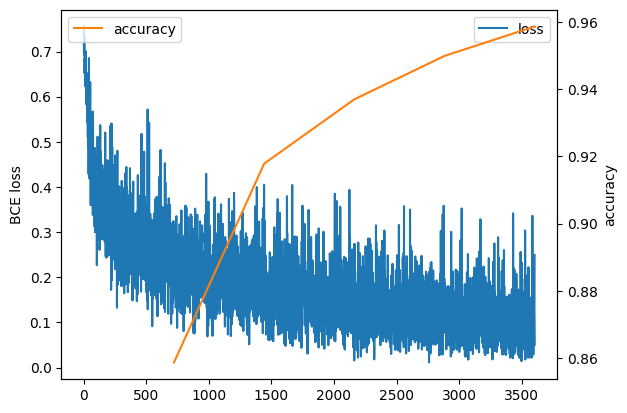

In [39]:
xs = np.arange(len(train_loader), len(loss_history) + len(train_loader), len(train_loader))

plt.plot(loss_history, label="loss")
plt.ylabel("BCE loss")
plt.legend()
plt.twinx()
plt.plot(xs, train_acc_history, label="accuracy", c="C1")
plt.ylabel("accuracy")
plt.legend()
plt.show()

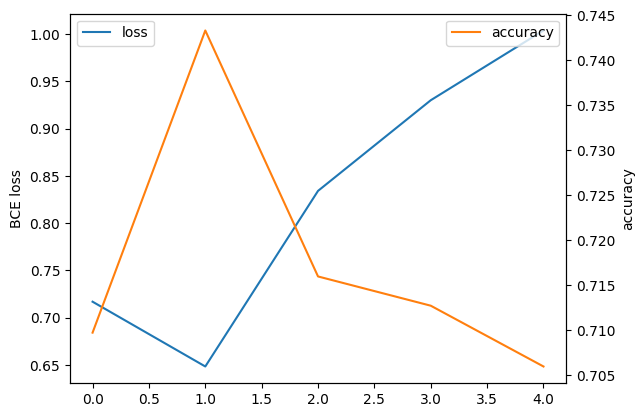

In [40]:
eval_loss_history = [x.cpu() for x in eval_loss_history]
plt.plot(eval_loss_history, label="loss")
plt.legend()
plt.ylabel("BCE loss")
plt.twinx()
plt.plot(eval_acc_history, c="C1", label="accuracy")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### Testing CNN + Transformer model
Use data augmentation and sliding window. Also bigger batch size.

In [41]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=augment_fn, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=test_augment)

In [42]:
model = CnnTransformerModel(in_features=30, dropout=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.BCEWithLogitsLoss()
EPOCHS = 5

In [43]:
loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(model, train_loader, optimizer, criterion, epoch, logging_steps=100)
    eval_acc, eval_loss = evaluate(model, test_loader, criterion)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)
    

0it [00:00, ?it/s]

Epoch: 0 (0/361) Training loss: 0.7406277060508728


123it [00:03, 37.54it/s]
3it [00:03,  1.05it/s]

Eval loss: 1.9164589643478394 Eval accuracy: 0.39418190717697144


100it [00:12, 10.34it/s]

Epoch: 0 (100/361) Training loss: 0.4031629264354706


123it [00:03, 37.83it/s]
103it [00:16,  2.00it/s]

Eval loss: 0.8559101223945618 Eval accuracy: 0.659870445728302


200it [00:25, 10.35it/s]

Epoch: 0 (200/361) Training loss: 0.22102101147174835


123it [00:03, 37.24it/s]
202it [00:29,  1.69it/s]

Eval loss: 0.6050084829330444 Eval accuracy: 0.7726752758026123


299it [00:38, 10.95it/s]

Epoch: 0 (300/361) Training loss: 0.236043319106102


123it [00:03, 37.64it/s]
303it [00:42,  2.29it/s]

Eval loss: 0.6521598696708679 Eval accuracy: 0.7598450183868408


361it [00:47,  7.58it/s]


Epoch 0 done. Training loss: 0.3621630370616913 Training accuracy: 0.8339248895645142


123it [00:03, 38.05it/s]


Eval loss: 0.5511586666107178 Eval accuracy: 0.7822027206420898


0it [00:00, ?it/s]

Epoch: 1 (0/361) Training loss: 0.29708555340766907


123it [00:03, 37.43it/s]
3it [00:03,  1.05it/s]

Eval loss: 0.5541045069694519 Eval accuracy: 0.7704522609710693


99it [00:12, 10.09it/s]

Epoch: 1 (100/361) Training loss: 0.2360435426235199


123it [00:03, 37.70it/s]
103it [00:16,  2.27it/s]

Eval loss: 0.676849365234375 Eval accuracy: 0.7716590166091919


199it [00:25, 10.35it/s]

Epoch: 1 (200/361) Training loss: 0.27582061290740967


123it [00:03, 37.41it/s]
203it [00:29,  2.26it/s]

Eval loss: 0.6625400185585022 Eval accuracy: 0.772357702255249


300it [00:38, 10.56it/s]

Epoch: 1 (300/361) Training loss: 0.2693621516227722


123it [00:03, 37.67it/s]
302it [00:42,  1.71it/s]

Eval loss: 0.8584818243980408 Eval accuracy: 0.6556148529052734


361it [00:48,  7.51it/s]


Epoch 1 done. Training loss: 0.2383703589439392 Training accuracy: 0.9021381735801697


123it [00:03, 38.02it/s]


Eval loss: 0.9069529175758362 Eval accuracy: 0.7116361856460571


0it [00:00, ?it/s]

Epoch: 2 (0/361) Training loss: 0.23247522115707397


123it [00:03, 37.35it/s]
2it [00:03,  1.46s/it]

Eval loss: 0.9999665021896362 Eval accuracy: 0.6937245726585388


99it [00:12, 10.28it/s]

Epoch: 2 (100/361) Training loss: 0.13533654808998108


123it [00:03, 37.08it/s]
102it [00:16,  1.96it/s]

Eval loss: 0.9657832384109497 Eval accuracy: 0.6652057766914368


200it [00:26, 10.30it/s]

Epoch: 2 (200/361) Training loss: 0.16669176518917084


123it [00:03, 37.47it/s]
202it [00:29,  1.69it/s]

Eval loss: 0.759524941444397 Eval accuracy: 0.6722561120986938


300it [00:39, 10.37it/s]

Epoch: 2 (300/361) Training loss: 0.15199542045593262


123it [00:03, 36.50it/s]
302it [00:42,  1.66it/s]

Eval loss: 0.8314635157585144 Eval accuracy: 0.6855944991111755


361it [00:48,  7.49it/s]


Epoch 2 done. Training loss: 0.20313552021980286 Training accuracy: 0.9166378378868103


123it [00:03, 38.23it/s]


Eval loss: 0.8876482844352722 Eval accuracy: 0.6970274448394775


0it [00:00, ?it/s]

Epoch: 3 (0/361) Training loss: 0.14832988381385803


123it [00:03, 37.12it/s]
3it [00:03,  1.04it/s]

Eval loss: 0.9304679036140442 Eval accuracy: 0.678036093711853


100it [00:12, 10.21it/s]

Epoch: 3 (100/361) Training loss: 0.22907857596874237


123it [00:03, 36.19it/s]
102it [00:16,  1.64it/s]

Eval loss: 0.9630091190338135 Eval accuracy: 0.6669842600822449


200it [00:26, 10.26it/s]

Epoch: 3 (200/361) Training loss: 0.2517063617706299


123it [00:03, 36.55it/s]
202it [00:29,  1.66it/s]

Eval loss: 0.7655683159828186 Eval accuracy: 0.7479674816131592


300it [00:39, 10.21it/s]

Epoch: 3 (300/361) Training loss: 0.1969640851020813


123it [00:03, 35.98it/s]
302it [00:42,  1.63it/s]

Eval loss: 0.7767012715339661 Eval accuracy: 0.7094131112098694


361it [00:48,  7.45it/s]


Epoch 3 done. Training loss: 0.17053593695163727 Training accuracy: 0.9296225905418396


123it [00:03, 38.21it/s]


Eval loss: 0.9869053959846497 Eval accuracy: 0.6986153721809387


0it [00:00, ?it/s]

Epoch: 4 (0/361) Training loss: 0.15426579117774963


123it [00:03, 36.91it/s]
3it [00:03,  1.04it/s]

Eval loss: 0.961027979850769 Eval accuracy: 0.7049669623374939


99it [00:13, 10.16it/s]

Epoch: 4 (100/361) Training loss: 0.26504844427108765


123it [00:03, 36.74it/s]
103it [00:16,  2.20it/s]

Eval loss: 1.0314280986785889 Eval accuracy: 0.7047129273414612


199it [00:26, 10.23it/s]

Epoch: 4 (200/361) Training loss: 0.18697836995124817


123it [00:03, 37.29it/s]
203it [00:29,  2.24it/s]

Eval loss: 0.9625993371009827 Eval accuracy: 0.7338033318519592


299it [00:39, 10.55it/s]

Epoch: 4 (300/361) Training loss: 0.2632746696472168


123it [00:03, 37.14it/s]
303it [00:42,  2.26it/s]

Eval loss: 0.8135457634925842 Eval accuracy: 0.7548907399177551


361it [00:48,  7.46it/s]


Epoch 4 done. Training loss: 0.1566411554813385 Training accuracy: 0.9348381161689758


123it [00:03, 38.42it/s]

Eval loss: 1.149094820022583 Eval accuracy: 0.6542174816131592


In [44]:
import matplotlib.pyplot as plt

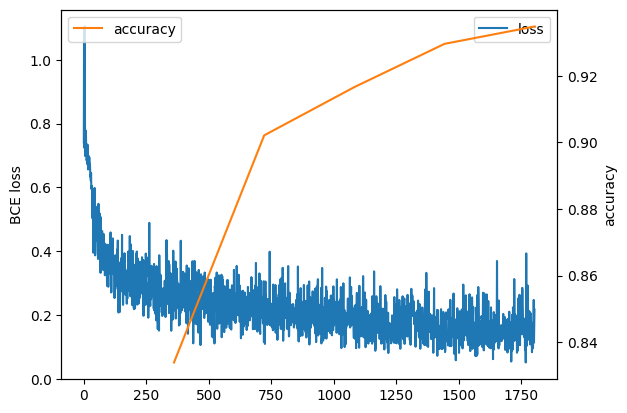

In [45]:
xs = np.arange(len(train_loader), len(loss_history) + len(train_loader), len(train_loader))

plt.plot(loss_history, label="loss")
plt.ylabel("BCE loss")
plt.legend()
plt.twinx()
plt.plot(xs, train_acc_history, label="accuracy", c="C1")
plt.ylabel("accuracy")
plt.legend()
plt.show()

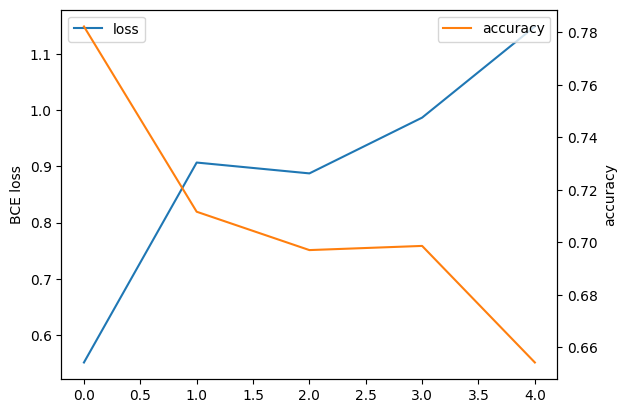

In [46]:
eval_loss_history = [x.cpu() for x in eval_loss_history]
plt.plot(eval_loss_history, label="loss")
plt.legend()
plt.ylabel("BCE loss")
plt.twinx()
plt.plot(eval_acc_history, c="C1", label="accuracy")
plt.ylabel("accuracy")
plt.legend()
plt.show()